# Import

Melakukan import library yang dibutuhkan dalam pengembangan sistem rekomendasi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

# Data Loading

Load dataset activities dan ratings dari file csv dan menampilkan jumlah baris dari masing-masing dataset

In [4]:
# Load data
activities = pd.read_csv('/content/activity.csv')
ratings = pd.read_csv('/content/rating.csv')

print("Jumlah data activities", len(activities))
print("Jumlah data ratings", len(ratings))

Jumlah data activities 150
Jumlah data ratings 1000


In [5]:
activities.head(5)

,activityId,name,category,duration,energy_needed
0,A001,Lari Santai Pagi,Olahraga,Sedang,Sedang-Tinggi
1,A002,Membaca Artikel Berita Online,Belajar,Singkat-Sedang,Rendah
2,A003,Memasak Sarapan Sehat,Produktivitas,Sedang,Sedang
3,A004,Meditasi Pernapasan 5 Menit,Relaksasi,Singkat,Rendah
4,A005,Membuat To-Do List Harian,Produktivitas,Singkat,Rendah


In [6]:
ratings.head(5)

,userId,activityId,rating,timestamp
0,User46,A143,4,12/01/2025 3:16
1,User35,A148,5,15/12/2024 14:06
2,User10,A148,5,26/07/2024 21:05
3,User4,A131,1,21/12/2024 07:26
4,User41,A084,5,26/10/2024 17:41


# Data Understanding

Memahami dataset yang akan digunakan, termasuk dengan beberapa visualisasi yang dibutuhkan untuk Exploratory Data Analysis

Menampilkan informasi singkat dari dataset activities

In [7]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   activityId     150 non-null    object
 1   name           150 non-null    object
 2   category       150 non-null    object
 3   duration       150 non-null    object
 4   energy_needed  150 non-null    object
dtypes: object(5)
memory usage: 6.0+ KB


Menampilkan informasi singkat dari dataset ratings

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      1000 non-null   object
 1   activityId  1000 non-null   object
 2   rating      1000 non-null   int64 
 3   timestamp   1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


Mendeskripsikan dataset activities, melihat distribusi data, nilai minimum, nilai maksimum, dan rata-rata dari data

In [9]:
ratings.describe()

,rating
count,1000.00000
mean,3.70600
std,1.31274
min,1.00000
25%,3.00000
50%,4.00000
75%,5.00000
max,5.00000


Melihat genre yang tersedia dari data, terdapat satu genre yang tidak seharusnya ada yaitu (no genres listed)

In [10]:
activities.category.unique()

array(['Olahraga', 'Belajar', 'Produktivitas', 'Relaksasi', 'Hiburan',
       'Kesehatan', 'Pengembangan Diri', 'Sosial', 'Kreativitas', 'Hobi',
       'Rumah Tangga'], dtype=object)

In [11]:
activities.duration.unique()

array(['Sedang', 'Singkat-Sedang', 'Singkat', 'Fleksibel', 'Sedang-Lama',
       'Lama'], dtype=object)

In [12]:
activities.energy_needed.unique()

array(['Sedang-Tinggi', 'Rendah', 'Sedang', 'Rendah-Sedang', 'Tinggi'],
      dtype=object)

# Data Preparation

## Cek Missing Value

In [13]:
# Mengecek missing value pada dataframe activities
activities.isnull().sum()

,0
activityId,0
name,0
category,0
duration,0
energy_needed,0


In [14]:
# Mengecek missing value pada dataframe ratings
ratings.isnull().sum()

,0
userId,0
activityId,0
rating,0
timestamp,0


## Cek Duplicate Value

In [15]:
# Mengecek duplicate value pada dataframe activities
activities.duplicated().sum()

np.int64(0)

In [16]:
# Mengecek duplicate value pada dataframe ratings
ratings.duplicated().sum()

np.int64(0)

## Content Based Filtering

Mempersiapkan data untuk digunakan pada recommendation system

### Ekstraksi Fitur TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Gabungkan fitur menjadi satu kolom teks
activities['features'] = activities['category'].astype(str) + ' ' + \
                         activities['duration'].astype(str) + ' ' + \
                         activities['energy_needed'].astype(str)

# Proses TF-IDF
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_matrix = tfidf.fit_transform(activities['features'])

In [18]:
# Menampilkan hasil dari TF-IDF Vectorizer
tfidf_feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=activities['name'], columns=tfidf_feature_names)

In [19]:
tfidf_df

,belajar,diri,fleksibel,hiburan,hobi,kesehatan,kreativitas,lama,olahraga,pengembangan,produktivitas,relaksasi,rendah,rumah,sedang,singkat,sosial,tangga,tinggi
name,,,,,,,,,,,,,,,,,,,
Lari Santai Pagi,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.560784,0.0,0.000000,0.000000,0.000000,0.000000,0.497796,0.000000,0.000000,0.000000,0.661604
Membaca Artikel Berita Online,0.788985,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.346748,0.000000,0.303331,0.406521,0.000000,0.000000,0.000000
Memasak Sarapan Sehat,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.758305,0.000000,0.000000,0.000000,0.651899,0.000000,0.000000,0.000000,0.000000
Meditasi Pernapasan 5 Menit,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.797251,0.391741,0.000000,0.000000,0.459270,0.000000,0.000000,0.000000
Membuat To-Do List Harian,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.797251,0.000000,0.391741,0.000000,0.000000,0.459270,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Bergabung dengan Sesi ""Speed Friending"" Online",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.632132,0.000000,0.774861,0.000000,0.000000
Membersihkan Peralatan Masak Secara Menyeluruh,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.615353,0.492626,0.000000,0.000000,0.615353,0.000000
Mengganti Baterai Alat Elektronik yang Mati,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.289559,0.632816,0.000000,0.339474,0.000000,0.632816,0.000000


## Collaborative Filtering

### Encode Label

In [20]:
# Copy data ke df
df = ratings

# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  ['User46', 'User35', 'User10', 'User4', 'User41', 'User31', 'User6', 'User30', 'User37', 'User18', 'User5', 'User12', 'User27', 'User36', 'User49', 'User28', 'User3', 'User19', 'User39', 'User9', 'User16', 'User24', 'User14', 'User42', 'User11', 'User25', 'User20', 'User8', 'User1', 'User32', 'User45', 'User44', 'User34', 'User23', 'User15', 'User7', 'User48', 'User26', 'User2', 'User22', 'User47', 'User50', 'User33', 'User40', 'User17', 'User13', 'User38', 'User43', 'User21', 'User29']
encoded userId :  {'User46': 0, 'User35': 1, 'User10': 2, 'User4': 3, 'User41': 4, 'User31': 5, 'User6': 6, 'User30': 7, 'User37': 8, 'User18': 9, 'User5': 10, 'User12': 11, 'User27': 12, 'User36': 13, 'User49': 14, 'User28': 15, 'User3': 16, 'User19': 17, 'User39': 18, 'User9': 19, 'User16': 20, 'User24': 21, 'User14': 22, 'User42': 23, 'User11': 24, 'User25': 25, 'User20': 26, 'User8': 27, 'User1': 28, 'User32': 29, 'User45': 30, 'User44': 31, 'User34': 32, 'User23': 33, 'User15': 34, 'U

In [21]:
# Mengubah activityId menjadi list tanpa nilai yang sama
activity_ids = df['activityId'].unique().tolist()

# Melakukan proses encoding activityId
activity_to_activity_encoded = {x: i for i, x in enumerate(activity_ids)}

# Melakukan proses encoding angka ke activityId
activity_encoded_to_activity = {i: x for i, x in enumerate(activity_ids)}

In [22]:
# Mapping userId ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)

# Mapping placeID ke dataframe activity
df['activity'] = df['activityId'].map(activity_to_activity_encoded)

### Split Data

In [23]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah activity
num_activity = len(activity_encoded_to_activity)
print(num_activity)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of activity: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_activity, min_rating, max_rating
))

50
147
Number of User: 50, Number of activity: 147, Min Rating: 1.0, Max Rating: 5.0


In [24]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,activityId,rating,timestamp,user,activity
521,User45,A111,4.0,26/05/2024 12:13,30,82
737,User15,A091,2.0,05/04/2025 9:45,34,65
740,User36,A078,5.0,05/04/2025 0:18,13,51
660,User41,A139,5.0,07/03/2024 1:57,4,56
411,User15,A068,2.0,09/01/2024 16:18,34,124
...,...,...,...,...,...,...
106,User13,A091,5.0,05/07/2024 14:05,45,65
270,User34,A029,4.0,03/09/2024 15:25,32,109
860,User36,A002,5.0,16/11/2024 04:24,13,60
435,User32,A076,4.0,01/04/2024 19:27,29,67


In [25]:
# Membuat variabel x untuk mencocokkan data user dan activity menjadi satu value
x = df[['user', 'activity']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[30 82]
 [34 65]
 [13 51]
 ...
 [13 60]
 [29 67]
 [31 64]] [0.75 0.25 1.   1.   0.25 0.5  0.25 1.   1.   0.75 0.75 1.   1.   0.75
 0.   1.   1.   1.   0.25 1.   0.75 0.75 0.75 0.   0.75 0.5  0.   0.25
 1.   0.75 0.5  1.   0.5  1.   0.75 0.75 1.   0.75 1.   0.75 0.   0.75
 0.   0.75 0.25 0.75 0.75 1.   1.   1.   0.75 0.75 0.75 0.75 0.5  0.75
 0.25 1.   1.   0.75 0.   0.75 1.   1.   1.   0.75 0.5  1.   0.75 1.
 0.5  1.   0.75 1.   0.75 1.   1.   1.   1.   1.   0.75 0.5  1.   0.75
 0.25 1.   0.75 1.   0.75 0.75 1.   1.   0.75 0.75 0.25 1.   1.   1.
 1.   1.   0.   0.25 0.75 0.25 0.25 0.5  1.   1.   1.   1.   0.75 0.75
 0.25 0.   0.75 0.75 0.75 1.   0.75 1.   0.75 0.75 1.   1.   0.   0.75
 0.75 1.   0.5  0.75 1.   0.5  1.   1.   1.   0.   0.75 0.75 0.25 1.
 0.25 0.   0.25 0.   1.   1.   0.25 0.75 0.75 1.   0.   0.75 1.   0.25
 0.5  0.   1.   0.75 0.75 1.   0.5  0.   0.5  0.25 1.   0.25 0.75 0.
 0.75 0.75 0.   0.25 0.25 0.25 0.   0.75 0.   1.   1.   0.25 0.25 1.
 0.5  0.75 1.   0.75 0.75 0

# Modeling and Result

Melakukan proses modeling untuk membuat sistem rekomendasi menggunakan konsep Content Based Filtering dan Colaborative Filtering

## Content Based Filtering

In [26]:
from sklearn.metrics.pairwise import linear_kernel

# Hitung cosine similarity antar aktivitas
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Mapping index ke nama aktivitas
activity_indices = pd.Series(activities.index, index=activities['name']).drop_duplicates()

# Fungsi rekomendasi lengkap dengan output
def content_based_recommendations(activity_name, top_n=10):
    idx = activity_indices.get(activity_name)
    if idx is None:
        print(f"Activity '{activity_name}' not found.")
        return

    print('Showing recommendations for: {}'.format(activity_name))
    print(activities[activities.name == activity_name])
    print('----' * 8)
    print('Top {} activity recommendations'.format(top_n))
    print('----' * 8)

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = [x for x in sim_scores if x[0] != idx]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_n+1]

    for i in sim_scores:
        rec = activities.iloc[i[0]]
        print(f"{rec['name']} ({rec['category']}, Duration: {rec['duration']}, Energy: {rec['energy_needed']})")

In [27]:
# Menampilkan korelasi antara film untuk rekomendasi
cosine_df = pd.DataFrame(cosine_sim, index=activities['name'], columns=activities['name'])

In [28]:
cosine_df

name,Lari Santai Pagi,Membaca Artikel Berita Online,Memasak Sarapan Sehat,Meditasi Pernapasan 5 Menit,Membuat To-Do List Harian,Mendengarkan Musik Favorit,Peregangan Ringan di Sela Kerja,Menulis Jurnal Pagi/Malam,Menonton Video Tutorial Singkat,Brainstorming Ide untuk Proyek,...,Latihan Kelincahan (Agility Ladder Drills jika ada),Bermain Frisbee di Lapangan Terbuka,"Mengikuti Kelas Dansa Online (Salsa, Hip-hop, dll.)",Mengirim Kartu Pos/Surat Fisik ke Teman Jauh,Menjadi Relawan Online untuk Proyek Singkat,"Bergabung dengan Sesi ""Speed Friending"" Online",Membersihkan Peralatan Masak Secara Menyeluruh,Mengganti Baterai Alat Elektronik yang Mati,Menyusun Rencana Darurat Keluarga Sederhana,Belajar Cara Memperbaiki Kerusakan Kecil di Rumah (mis. keran bocor via tutorial)
name,,,,,,,,,,,,,,,,,,,,,
Lari Santai Pagi,1.000000,0.150997,0.324513,0.000000,0.000000,0.000000,0.000000,0.120426,0.267343,0.324513,...,0.948616,0.749853,0.893945,0.000000,0.122559,0.314673,0.245227,0.000000,0.304090,0.219676
Membaca Artikel Berita Online,0.150997,1.000000,0.197741,0.322538,0.322538,0.100689,0.246145,0.301073,0.966710,0.197741,...,0.271874,0.201369,0.134983,0.311778,0.172270,0.191745,0.149429,0.238407,0.306365,0.133859
Memasak Sarapan Sehat,0.324513,0.197741,1.000000,0.000000,0.604560,0.000000,0.000000,0.157706,0.350104,1.000000,...,0.307838,0.432769,0.290097,0.000000,0.160499,0.412086,0.321143,0.000000,0.937065,0.287682
Meditasi Pernapasan 5 Menit,0.000000,0.322538,0.000000,1.000000,0.364390,0.113754,0.278085,0.257236,0.285529,0.000000,...,0.145327,0.000000,0.000000,0.352234,0.110252,0.000000,0.000000,0.269342,0.136778,0.000000
Membuat To-Do List Harian,0.000000,0.322538,0.604560,0.364390,1.000000,0.113754,0.278085,0.257236,0.285529,0.604560,...,0.145327,0.000000,0.000000,0.352234,0.110252,0.000000,0.000000,0.269342,0.703290,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Bergabung dengan Sesi ""Speed Friending"" Online",0.314673,0.191745,0.412086,0.000000,0.000000,0.000000,0.000000,0.152924,0.339487,0.412086,...,0.298504,0.419646,0.281300,0.629269,0.623327,1.000000,0.311404,0.000000,0.386152,0.278958
Membersihkan Peralatan Masak Secara Menyeluruh,0.245227,0.149429,0.321143,0.000000,0.000000,0.000000,0.000000,0.119175,0.264566,0.321143,...,0.232627,0.327034,0.219220,0.000000,0.121286,0.311404,1.000000,0.778811,0.300931,0.895807
Mengganti Baterai Alat Elektronik yang Mati,0.000000,0.238407,0.000000,0.269342,0.269342,0.084082,0.205549,0.190139,0.211052,0.000000,...,0.107420,0.000000,0.000000,0.260357,0.081494,0.000000,0.778811,1.000000,0.101101,0.697664


In [29]:
content_based_recommendations("Menjadi Relawan Online untuk Proyek Singkat")

Showing recommendations for: Menjadi Relawan Online untuk Proyek Singkat
    activityId                                         name category  \
144       A145  Menjadi Relawan Online untuk Proyek Singkat   Sosial   

      duration  energy_needed                        features  
144  Fleksibel  Rendah-Sedang  Sosial Fleksibel Rendah-Sedang  
--------------------------------
Top 10 activity recommendations
--------------------------------
Menawarkan Bantuan kepada Tetangga/Rekan (Sosial, Duration: Fleksibel, Energy: Rendah-Sedang)
Memberi Dukungan Emosional pada Teman Curhat (Sosial, Duration: Fleksibel, Energy: Rendah-Sedang)
Ikut Diskusi di Grup Online Sesuai Minat (Sosial, Duration: Sedang, Energy: Rendah-Sedang)
Bertukar Rekomendasi Buku/Film dengan Teman (Sosial, Duration: Singkat-Sedang, Energy: Rendah)
Merencanakan Pertemuan (Online/Offline) (Sosial, Duration: Singkat-Sedang, Energy: Rendah-Sedang)
Bergabung dengan Sesi "Speed Friending" Online (Sosial, Duration: Sedang, Energy

## Collaborative Filtering

In [30]:
@tf.keras.utils.register_keras_serializable()
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_activity, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_activity = num_activity
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.activity_embedding = layers.Embedding(
            num_activity, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.activity_bias = layers.Embedding(num_activity, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        activity_vector = self.activity_embedding(inputs[:, 1])
        activity_bias = self.activity_bias(inputs[:, 1])

        dot_user_activity = tf.tensordot(user_vector, activity_vector, 2)
        x = dot_user_activity + user_bias + activity_bias
        return tf.nn.sigmoid(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_users": self.num_users,
            "num_activity": self.num_activity,
            "embedding_size": self.embedding_size
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(
            num_users=config.pop("num_users"),
            num_activity=config.pop("num_activity"),
            embedding_size=config.pop("embedding_size"),
            **config
        )

In [31]:
model = RecommenderNet(num_users, num_activity, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [32]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.7102 - root_mean_squared_error: 0.3800 - val_loss: 0.6827 - val_root_mean_squared_error: 0.3742
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6510 - root_mean_squared_error: 0.3374 - val_loss: 0.6628 - val_root_mean_squared_error: 0.3611
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6290 - root_mean_squared_error: 0.3191 - val_loss: 0.6468 - val_root_mean_squared_error: 0.3503
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6039 - root_mean_squared_error: 0.3048 - val_loss: 0.6364 - val_root_mean_squared_error: 0.3431
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6051 - root_mean_squared_error: 0.3021 - val_loss: 0.6280 - val_root_mean_squared_error: 0.3374
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5842 - root_mean_squared_error: 0.2964 - val_loss: 0.6246 - val_root_mean_squared_error: 0.3352
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

In [33]:
# Simpan model setelah training selesai
model.save("collaborative.keras")

In [39]:
model.export("recommender_saved_model")  # Direktori ini akan berisi SavedModel

Saved artifact at 'recommender_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134260888341584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134260888341968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134260888343888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134260888343504: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [43]:
import tensorflow as tf

# Konversi dari direktori SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model("recommender_saved_model")
tflite_model = converter.convert()

# Simpan ke file .tflite
with open("recommender_model.tflite", "wb") as f:
    f.write(tflite_model)


In [34]:
activity_df = activities
df = pd.read_csv('rating.csv')

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
activity_watched_by_user = df[df.userId == user_id]

# Operator bitwise (~)
activity_not_watched = activity_df[~activity_df['activityId'].isin(activity_watched_by_user.activityId.values)]['activityId']
activity_not_watched = list(
    set(activity_not_watched)
    .intersection(set(activity_to_activity_encoded.keys()))
)

activity_not_watched = [[activity_to_activity_encoded.get(x)] for x in activity_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_activity_array = np.hstack(
    ([[user_encoder]] * len(activity_not_watched), activity_not_watched)
)

In [35]:
ratings = model.predict(user_activity_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_activity_ids = [
    activity_encoded_to_activity.get(activity_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('activity with high ratings from user')
print('----' * 8)

top_activity_user = (
    activity_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .activityId.values
)

activity_df_rows = activity_df[activity_df['activityId'].isin(top_activity_user)]
for row in activity_df_rows.itertuples():
    print(row.name, ':', row.features)

print('----' * 8)
print('Top 10 activity recommendation')
print('----' * 8)

recommended_activity = activity_df[activity_df['activityId'].isin(recommended_activity_ids)]
for row in recommended_activity.itertuples():
    print(row.name, ':', row.features)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Showing recommendations for users: User44
activity with high ratings from user
--------------------------------
Membaca Artikel Berita Online : Belajar Singkat-Sedang Rendah
Berkebun Skala Kecil (Tanaman Pot) : Hobi Sedang Rendah-Sedang
Melihat Foto-foto Liburan Lama : Relaksasi Singkat-Sedang Rendah
Mengadakan Nonton Bareng Virtual (Watch Party) : Hiburan Lama Rendah
Menyiapkan Pakaian untuk Besok Pagi : Produktivitas Singkat Rendah
--------------------------------
Top 10 activity recommendation
--------------------------------
Memasak Sarapan Sehat : Produktivitas Sedang Sedang
Naik Turun Tangga Beberapa Kali : Kesehatan Singkat Sedang
Mengikuti Video Senam Aerobik Intensitas Rendah : Olahraga Sedang Sedang
Latihan Push-up (Variasi sesuai kemampuan) : Olahraga Singkat Sedang-Tinggi
Pendinginan Setelah Olahraga (Peregangan Statis) : Olahraga Singkat Rendah
Bermain Game Online Multi-pemain Santai : Hiburan Sedang-Lama Sedang
Menulis Ucapan Terima 

# Evaluation

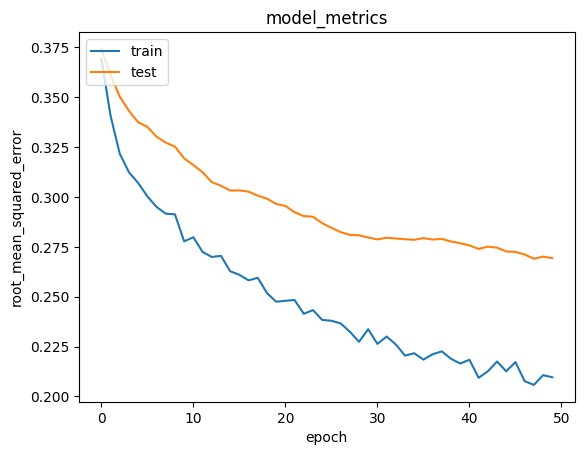

In [36]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
import json

# Simpan mapping user dan activity
with open("user_to_user_encoded.json", "w") as f:
    json.dump(user_to_user_encoded, f)

with open("activity_to_activity_encoded.json", "w") as f:
    json.dump(activity_to_activity_encoded, f)

# Decoder (optional)
with open("user_encoded_to_user.json", "w") as f:
    json.dump(user_encoded_to_user, f)

with open("activity_encoded_to_activity.json", "w") as f:
    json.dump(activity_encoded_to_activity, f)